# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
#!unzip processed-celeba-small.zip

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [ToTensor(),
                 Resize(size),
                 Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
#import os
#import os.path
import pandas as pd

#filesnames = pd.Series([f[:-4] for f in os.listdir(data_dir)
#                   if os.path.isfile(os.path.join(data_dir, f))])
#filesnames.to_csv("imagenames.csv")

In [5]:
filesnames = pd.read_csv("imagenames.csv", index_col='Unnamed: 0').squeeze("columns")

In [6]:
filesnames.describe()

count      32601
unique     32601
top       188314
freq           1
Name: 0, dtype: object

In [7]:
def scale(x):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''

    x_temp = (x - x.min())/(x.max()-x.min())
    x_out = x_temp*2-1

    return x_out

In [8]:
import glob
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '*.jpg'):
        # TODO: implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(glob.glob1(self.directory,self.extension))
    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        dir_path = self.directory+'*.jpg'
        files = glob.glob(dir_path)
        file = Image.open(files[index])
        transform_function = get_transforms((64,64))
        file_tr = transform_function(file)
        file_tr_sc = scale(file_tr.numpy()) 
        image_tr_sc_tens = torch.tensor(file_tr_sc)
        return image_tr_sc_tens

In [9]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

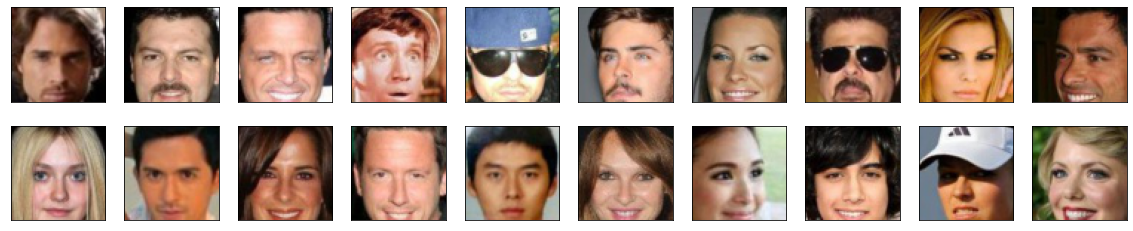

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [11]:
from torch.nn import Module
from torch import nn

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        fmaps = 64
        kernel_size = 4
        stride = 2
        padding = 1
        bias = False
        
        
        self.discrim = nn.Sequential(
            # block 1
            nn.Conv2d(in_channels=3,
                      out_channels=fmaps,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # block 2
            nn.Conv2d(in_channels=fmaps,
                      out_channels=fmaps*2,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(num_features=fmaps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # block 3
            nn.Conv2d(in_channels=fmaps*2,
                      out_channels=fmaps*4,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(num_features=fmaps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # block 4
            nn.Conv2d(in_channels=fmaps*4,
                      out_channels=fmaps*8,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(num_features=fmaps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # block 5
            nn.Conv2d(in_channels=fmaps*8,
                      out_channels=1,
                      kernel_size=kernel_size, stride=1, padding=0, bias=bias),
            #nn.Sigmoid()
            
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.discrim(x)

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        
        fmaps = 64
        kernel_size = 4
        stride = 2
        padding = 1
        bias = False
        
        
        # TODO: instantiate the different layers
        self.gene = nn.Sequential(
            # block 1
            nn.ConvTranspose2d(in_channels=latent_dim,
                               out_channels=fmaps * 8,
                               kernel_size=4, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(fmaps * 8),
            nn.ReLU(True),
            
            
            # block 2
            nn.ConvTranspose2d(in_channels=fmaps * 8,
                               out_channels=fmaps * 4,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(fmaps * 4),
            nn.ReLU(True),
            
            
            # block 3
            nn.ConvTranspose2d(in_channels=fmaps * 4,
                               out_channels=fmaps * 2,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(fmaps * 2),
            nn.ReLU(True),
            
            
            # block 4
            nn.ConvTranspose2d(in_channels=fmaps * 2,
                               out_channels=fmaps * 1,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(fmaps * 1),
            nn.ReLU(True),
            
            
            # block 5
            nn.ConvTranspose2d(in_channels=fmaps * 1,
                               out_channels=3,
                               kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.Tanh()
        )
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        return self.gene(x)

In [15]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [16]:
import torch.optim as optim
lr = 0.0002
beta1=0.5
beta2=0.999 

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [17]:
#def generator_loss(fake_logits):
#    """ Generator loss, takes the fake scores as inputs. """
#    # TODO: implement the generator loss 
#    loss = torch.ones_like(fake_logits)
#    loss = 0.9*loss
#    bce = nn.BCEWithLogitsLoss()
#    loss = bce(fake_logits, loss)
#    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [18]:
#def discriminator_loss(real_logits, fake_logits):
#    """ Discriminator loss, takes the fake and real logits as inputs. """
#    # TODO: implement the discriminator loss
#    bce = nn.BCEWithLogitsLoss()#.BCELoss()#.
#    loss = criterion(real_logits, fake_logits)
#    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [19]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [20]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [21]:
from datetime import datetime

In [22]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 10

# number of images in each batch
batch_size = 64

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [25]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    #if train_on_gpu:
    labels = labels.to(device)
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    #if train_on_gpu:
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

2023-03-23 15:03:49 | Epoch [1/10] | Batch 0/509 | d_loss: 1.4332 | g_loss: 2.2227
2023-03-23 15:06:34 | Epoch [1/10] | Batch 50/509 | d_loss: 0.0806 | g_loss: 9.7333
2023-03-23 15:09:31 | Epoch [1/10] | Batch 100/509 | d_loss: 0.4590 | g_loss: 3.9947
2023-03-23 15:12:15 | Epoch [1/10] | Batch 150/509 | d_loss: 0.4114 | g_loss: 3.6211
2023-03-23 15:15:11 | Epoch [1/10] | Batch 200/509 | d_loss: 1.1506 | g_loss: 9.4696
2023-03-23 15:17:57 | Epoch [1/10] | Batch 250/509 | d_loss: 0.5087 | g_loss: 3.4151
2023-03-23 15:20:54 | Epoch [1/10] | Batch 300/509 | d_loss: 0.1654 | g_loss: 3.0834
2023-03-23 15:23:39 | Epoch [1/10] | Batch 350/509 | d_loss: 0.4213 | g_loss: 2.5162
2023-03-23 15:26:35 | Epoch [1/10] | Batch 400/509 | d_loss: 0.3319 | g_loss: 4.3697
2023-03-23 15:29:19 | Epoch [1/10] | Batch 450/509 | d_loss: 0.5158 | g_loss: 3.2542
2023-03-23 15:32:15 | Epoch [1/10] | Batch 500/509 | d_loss: 0.5853 | g_loss: 6.2923


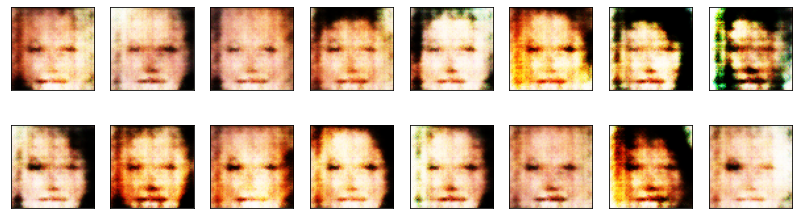

2023-03-23 15:32:51 | Epoch [2/10] | Batch 0/509 | d_loss: 0.4738 | g_loss: 3.9543
2023-03-23 15:35:35 | Epoch [2/10] | Batch 50/509 | d_loss: 0.6802 | g_loss: 1.2932
2023-03-23 15:38:30 | Epoch [2/10] | Batch 100/509 | d_loss: 0.4857 | g_loss: 3.1849
2023-03-23 15:41:13 | Epoch [2/10] | Batch 150/509 | d_loss: 0.2665 | g_loss: 4.4639
2023-03-23 15:44:08 | Epoch [2/10] | Batch 200/509 | d_loss: 0.5091 | g_loss: 6.6033
2023-03-23 15:46:53 | Epoch [2/10] | Batch 250/509 | d_loss: 0.2781 | g_loss: 4.2797
2023-03-23 15:49:47 | Epoch [2/10] | Batch 300/509 | d_loss: 0.6964 | g_loss: 4.9962
2023-03-23 15:52:32 | Epoch [2/10] | Batch 350/509 | d_loss: 0.7448 | g_loss: 3.6316
2023-03-23 15:55:24 | Epoch [2/10] | Batch 400/509 | d_loss: 0.4122 | g_loss: 3.6525
2023-03-23 15:58:12 | Epoch [2/10] | Batch 450/509 | d_loss: 0.2133 | g_loss: 4.8448
2023-03-23 16:01:02 | Epoch [2/10] | Batch 500/509 | d_loss: 0.4200 | g_loss: 4.7587


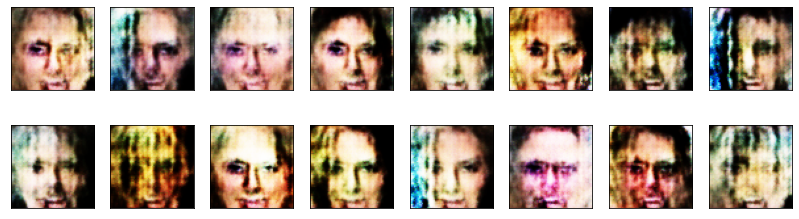

2023-03-23 16:01:39 | Epoch [3/10] | Batch 0/509 | d_loss: 1.0687 | g_loss: 6.2282
2023-03-23 16:04:22 | Epoch [3/10] | Batch 50/509 | d_loss: 0.8468 | g_loss: 1.3001
2023-03-23 16:07:16 | Epoch [3/10] | Batch 100/509 | d_loss: 0.6161 | g_loss: 6.4130
2023-03-23 16:10:01 | Epoch [3/10] | Batch 150/509 | d_loss: 0.2380 | g_loss: 3.5216
2023-03-23 16:12:55 | Epoch [3/10] | Batch 200/509 | d_loss: 0.2944 | g_loss: 3.6598
2023-03-23 16:15:42 | Epoch [3/10] | Batch 250/509 | d_loss: 0.7079 | g_loss: 6.1011
2023-03-23 16:18:32 | Epoch [3/10] | Batch 300/509 | d_loss: 0.8068 | g_loss: 7.4537
2023-03-23 16:21:22 | Epoch [3/10] | Batch 350/509 | d_loss: 0.8152 | g_loss: 6.2315
2023-03-23 16:24:09 | Epoch [3/10] | Batch 400/509 | d_loss: 0.3034 | g_loss: 5.6387
2023-03-23 16:27:01 | Epoch [3/10] | Batch 450/509 | d_loss: 0.9190 | g_loss: 4.5323
2023-03-23 16:29:46 | Epoch [3/10] | Batch 500/509 | d_loss: 0.4383 | g_loss: 3.3571


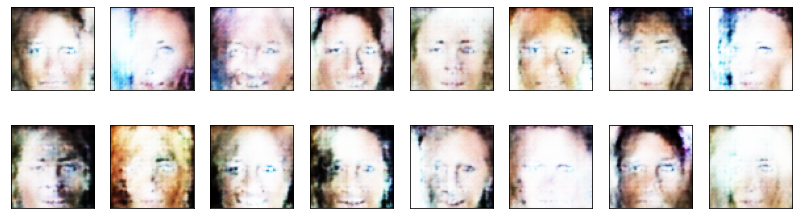

2023-03-23 16:30:25 | Epoch [4/10] | Batch 0/509 | d_loss: 0.7186 | g_loss: 3.0798
2023-03-23 16:33:08 | Epoch [4/10] | Batch 50/509 | d_loss: 0.5813 | g_loss: 4.8397
2023-03-23 16:36:03 | Epoch [4/10] | Batch 100/509 | d_loss: 0.1484 | g_loss: 4.9596
2023-03-23 16:38:47 | Epoch [4/10] | Batch 150/509 | d_loss: 0.4238 | g_loss: 5.4673
2023-03-23 16:41:40 | Epoch [4/10] | Batch 200/509 | d_loss: 0.7980 | g_loss: 4.5364
2023-03-23 16:44:28 | Epoch [4/10] | Batch 250/509 | d_loss: 0.3481 | g_loss: 2.1413
2023-03-23 16:47:16 | Epoch [4/10] | Batch 300/509 | d_loss: 1.2247 | g_loss: 2.7569
2023-03-23 16:50:08 | Epoch [4/10] | Batch 350/509 | d_loss: 1.3192 | g_loss: 9.2908
2023-03-23 16:52:52 | Epoch [4/10] | Batch 400/509 | d_loss: 0.2322 | g_loss: 4.4147
2023-03-23 16:55:47 | Epoch [4/10] | Batch 450/509 | d_loss: 1.0877 | g_loss: 8.3611
2023-03-23 16:58:31 | Epoch [4/10] | Batch 500/509 | d_loss: 0.1677 | g_loss: 3.0615


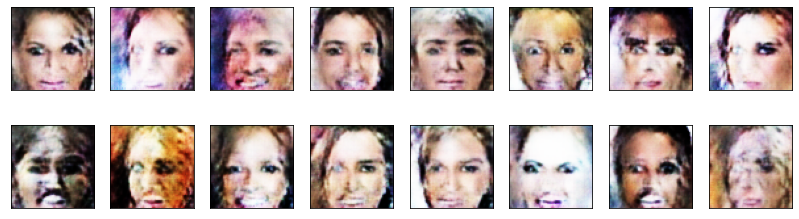

2023-03-23 16:59:10 | Epoch [5/10] | Batch 0/509 | d_loss: 0.4955 | g_loss: 3.5741
2023-03-23 17:01:55 | Epoch [5/10] | Batch 50/509 | d_loss: 0.5172 | g_loss: 4.6796
2023-03-23 17:04:50 | Epoch [5/10] | Batch 100/509 | d_loss: 0.2634 | g_loss: 4.8887
2023-03-23 17:07:34 | Epoch [5/10] | Batch 150/509 | d_loss: 0.4363 | g_loss: 2.5481
2023-03-23 17:10:29 | Epoch [5/10] | Batch 200/509 | d_loss: 3.2284 | g_loss: 4.2069
2023-03-23 17:13:13 | Epoch [5/10] | Batch 250/509 | d_loss: 0.3538 | g_loss: 4.6934
2023-03-23 17:16:09 | Epoch [5/10] | Batch 300/509 | d_loss: 0.2446 | g_loss: 3.2773
2023-03-23 17:18:53 | Epoch [5/10] | Batch 350/509 | d_loss: 0.2263 | g_loss: 3.0044
2023-03-23 17:21:50 | Epoch [5/10] | Batch 400/509 | d_loss: 0.1659 | g_loss: 3.0362
2023-03-23 17:24:34 | Epoch [5/10] | Batch 450/509 | d_loss: 0.8316 | g_loss: 6.3682
2023-03-23 17:27:32 | Epoch [5/10] | Batch 500/509 | d_loss: 0.4112 | g_loss: 5.5095


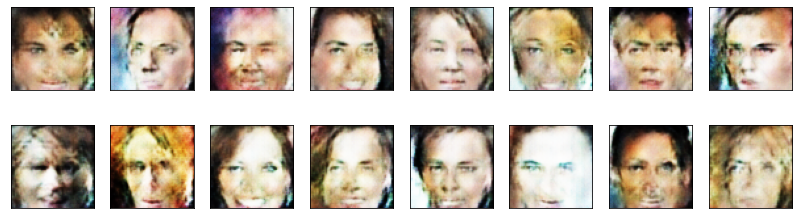

2023-03-23 17:28:08 | Epoch [6/10] | Batch 0/509 | d_loss: 0.1615 | g_loss: 4.2589
2023-03-23 17:30:52 | Epoch [6/10] | Batch 50/509 | d_loss: 0.1725 | g_loss: 4.8173
2023-03-23 17:33:47 | Epoch [6/10] | Batch 100/509 | d_loss: 0.1981 | g_loss: 4.2089
2023-03-23 17:36:32 | Epoch [6/10] | Batch 150/509 | d_loss: 0.1718 | g_loss: 4.0881
2023-03-23 17:39:26 | Epoch [6/10] | Batch 200/509 | d_loss: 0.2594 | g_loss: 4.9588
2023-03-23 17:42:10 | Epoch [6/10] | Batch 250/509 | d_loss: 0.3767 | g_loss: 5.0912
2023-03-23 17:45:04 | Epoch [6/10] | Batch 300/509 | d_loss: 0.4520 | g_loss: 2.4639
2023-03-23 17:47:49 | Epoch [6/10] | Batch 350/509 | d_loss: 0.3966 | g_loss: 2.2661
2023-03-23 17:50:41 | Epoch [6/10] | Batch 400/509 | d_loss: 0.5053 | g_loss: 4.7100
2023-03-23 17:53:27 | Epoch [6/10] | Batch 450/509 | d_loss: 0.3046 | g_loss: 3.6999
2023-03-23 17:56:20 | Epoch [6/10] | Batch 500/509 | d_loss: 0.1766 | g_loss: 3.1780


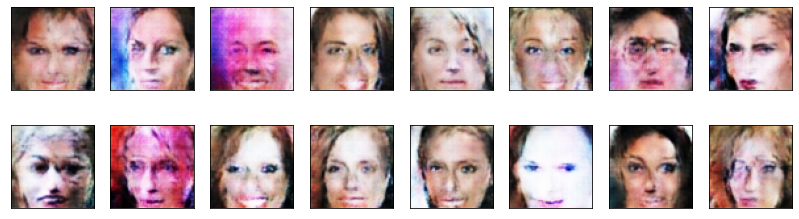

2023-03-23 17:56:58 | Epoch [7/10] | Batch 0/509 | d_loss: 0.2938 | g_loss: 3.6390
2023-03-23 17:59:43 | Epoch [7/10] | Batch 50/509 | d_loss: 0.4696 | g_loss: 5.7640
2023-03-23 18:02:40 | Epoch [7/10] | Batch 100/509 | d_loss: 0.2442 | g_loss: 4.6864
2023-03-23 18:05:24 | Epoch [7/10] | Batch 150/509 | d_loss: 0.0916 | g_loss: 4.4238
2023-03-23 18:08:20 | Epoch [7/10] | Batch 200/509 | d_loss: 0.0942 | g_loss: 3.6269
2023-03-23 18:11:04 | Epoch [7/10] | Batch 250/509 | d_loss: 0.5548 | g_loss: 3.3119
2023-03-23 18:14:02 | Epoch [7/10] | Batch 300/509 | d_loss: 0.2787 | g_loss: 2.5071
2023-03-23 18:16:47 | Epoch [7/10] | Batch 350/509 | d_loss: 0.1356 | g_loss: 3.5145
2023-03-23 18:19:44 | Epoch [7/10] | Batch 400/509 | d_loss: 0.4789 | g_loss: 6.4371
2023-03-23 18:22:28 | Epoch [7/10] | Batch 450/509 | d_loss: 0.1797 | g_loss: 2.1188
2023-03-23 18:25:25 | Epoch [7/10] | Batch 500/509 | d_loss: 0.6781 | g_loss: 6.5431


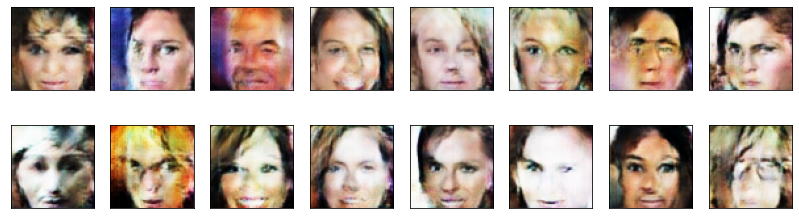

2023-03-23 18:25:59 | Epoch [8/10] | Batch 0/509 | d_loss: 0.7046 | g_loss: 6.0439
2023-03-23 18:28:44 | Epoch [8/10] | Batch 50/509 | d_loss: 0.3093 | g_loss: 6.1703
2023-03-23 18:31:41 | Epoch [8/10] | Batch 100/509 | d_loss: 0.1256 | g_loss: 2.7602
2023-03-23 18:34:25 | Epoch [8/10] | Batch 150/509 | d_loss: 0.0466 | g_loss: 7.8098
2023-03-23 18:37:22 | Epoch [8/10] | Batch 200/509 | d_loss: 0.0429 | g_loss: 5.0846
2023-03-23 18:40:06 | Epoch [8/10] | Batch 250/509 | d_loss: 0.2177 | g_loss: 3.0220
2023-03-23 18:43:04 | Epoch [8/10] | Batch 300/509 | d_loss: 0.2558 | g_loss: 5.4518
2023-03-23 18:45:50 | Epoch [8/10] | Batch 350/509 | d_loss: 3.0811 | g_loss: 9.3078
2023-03-23 18:48:47 | Epoch [8/10] | Batch 400/509 | d_loss: 0.3847 | g_loss: 3.9458
2023-03-23 18:51:32 | Epoch [8/10] | Batch 450/509 | d_loss: 0.0567 | g_loss: 5.6356
2023-03-23 18:54:29 | Epoch [8/10] | Batch 500/509 | d_loss: 0.3792 | g_loss: 3.2936


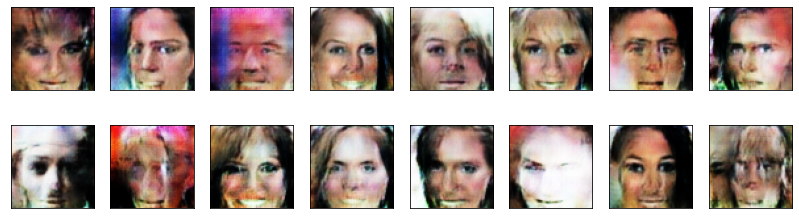

2023-03-23 18:55:04 | Epoch [9/10] | Batch 0/509 | d_loss: 0.3367 | g_loss: 5.1504
2023-03-23 18:57:49 | Epoch [9/10] | Batch 50/509 | d_loss: 1.0598 | g_loss: 7.1138
2023-03-23 19:00:46 | Epoch [9/10] | Batch 100/509 | d_loss: 0.0463 | g_loss: 6.0981
2023-03-23 19:03:30 | Epoch [9/10] | Batch 150/509 | d_loss: 0.8149 | g_loss: 6.4524
2023-03-23 19:06:26 | Epoch [9/10] | Batch 200/509 | d_loss: 0.2373 | g_loss: 5.0776
2023-03-23 19:09:10 | Epoch [9/10] | Batch 250/509 | d_loss: 0.3972 | g_loss: 4.6642
2023-03-23 19:12:06 | Epoch [9/10] | Batch 300/509 | d_loss: 0.3923 | g_loss: 5.2663
2023-03-23 19:14:51 | Epoch [9/10] | Batch 350/509 | d_loss: 0.0222 | g_loss: 4.9596
2023-03-23 19:17:46 | Epoch [9/10] | Batch 400/509 | d_loss: 0.0382 | g_loss: 7.9136
2023-03-23 19:20:31 | Epoch [9/10] | Batch 450/509 | d_loss: 0.2488 | g_loss: 4.3187
2023-03-23 19:23:27 | Epoch [9/10] | Batch 500/509 | d_loss: 0.0659 | g_loss: 6.5417


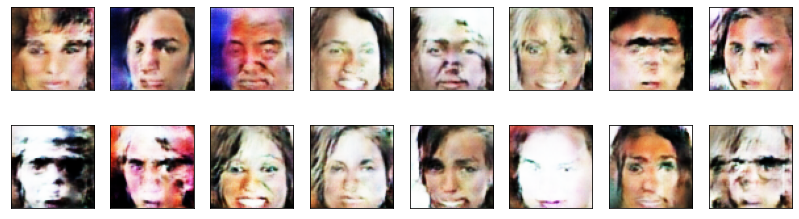

2023-03-23 19:24:04 | Epoch [10/10] | Batch 0/509 | d_loss: 0.0344 | g_loss: 5.3136
2023-03-23 19:26:48 | Epoch [10/10] | Batch 50/509 | d_loss: 0.0068 | g_loss: 8.2881
2023-03-23 19:29:45 | Epoch [10/10] | Batch 100/509 | d_loss: 0.1615 | g_loss: 5.6623
2023-03-23 19:32:30 | Epoch [10/10] | Batch 150/509 | d_loss: 0.2992 | g_loss: 4.0186
2023-03-23 19:35:26 | Epoch [10/10] | Batch 200/509 | d_loss: 0.0307 | g_loss: 4.6212
2023-03-23 19:38:10 | Epoch [10/10] | Batch 250/509 | d_loss: 0.1049 | g_loss: 5.4760
2023-03-23 19:41:07 | Epoch [10/10] | Batch 300/509 | d_loss: 0.6089 | g_loss: 5.9886
2023-03-23 19:43:51 | Epoch [10/10] | Batch 350/509 | d_loss: 0.0620 | g_loss: 6.4813
2023-03-23 19:46:48 | Epoch [10/10] | Batch 400/509 | d_loss: 0.0665 | g_loss: 2.9829
2023-03-23 19:49:33 | Epoch [10/10] | Batch 450/509 | d_loss: 0.0219 | g_loss: 6.3553
2023-03-23 19:52:29 | Epoch [10/10] | Batch 500/509 | d_loss: 0.0329 | g_loss: 4.4154


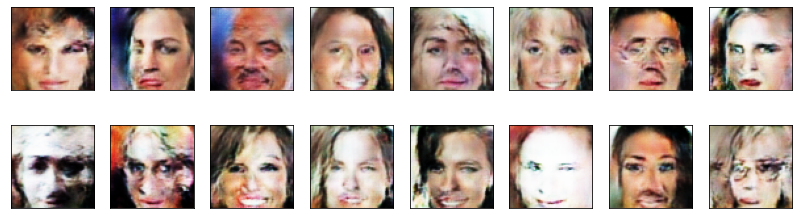

In [26]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        real_images = scale(real_images)
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        
        
        
        d_optimizer.zero_grad()
        
        # Compute the discriminator losses on real images 
        D_real = discriminator(real_images)
        d_real_loss = real_loss(D_real)
        z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
        z = torch.from_numpy(z).float()
        z = z.cuda()
        #z.to(device)
        
        fake_images = generator(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = discriminator(fake_images.detach())
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        g_optimizer.zero_grad()
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
        z = torch.from_numpy(z).float()
        z = z.cuda()
        #z.to(device)
        
        fake_images = generator(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = discriminator(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        
        
        
        
        
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss.item() #d_loss['loss'].item()
            g = g_loss.item()#g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

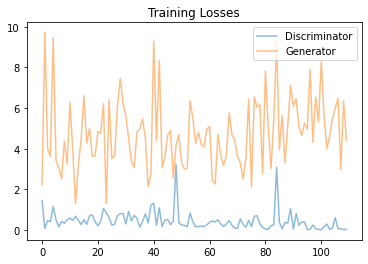

In [27]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** the generated sample is quite blurred and the face edges are decaying.
we can improve the model by maybe altering the model and a mentor told me maybe use  MSE loss or WGAN loss as the loss functions.
regarding the baised dataset maybe adding more pales skin and black skin faces can help 


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.